In [2]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, print_full
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n
set_plot_params()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse

ModuleNotFoundError: No module named 'modules'

In [138]:
exp_path = "../models/tensorboard/visnav/behavior_predict/"
# exp_path = "../models/tensorboard/visnav/behavior_predict/classification"
# get the folders in exp_path
# folders = glob.glob(exp_path + "/*")
model_dirs = glob.glob(exp_path + "**/**.pt", recursive=True)
model_dirs = [os.path.dirname(m) for m in model_dirs]

In [139]:
model_dirs

['../models/tensorboard/visnav/behavior_predict/no_classification/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25',
 '../models/tensorboard/visnav/behavior_predict/long_no_classification/no_pretraining_0.1/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25',
 '../models/tensorboard/visnav/behavior_predict/long_no_classification/no_pretraining_0.1/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/6_Cont:False_window:0.05_f_window:0.2_df:0.005_blocksize:100_conv_True_shuffle:True_batch:16_sparse_(None_None)_blocksz446_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_52_max0.005_(8, 8, 8)_8_256',
 '../models/tensorboard/visnav/behavior_predict/long_no_classification/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25',
 '../models/tensorboard/visnav/behavior_predict/long_no_classification/finetune/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25',
 '../models/tensorboard/visnav/behavior_predict/long_no_classification/finetuning_0.1/window:0.05

In [140]:
behavior_pred_path = glob.glob(model_dir + "**/behavior_preds.csv", recursive=True)
behavior_pred_path

[]

['../models/tensorboard/visnav/behavior_predict/no_classification/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_preds.csv']
['../models/tensorboard/visnav/behavior_predict/long_no_classification/no_pretraining_0.1/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_preds.csv']
[]
['../models/tensorboard/visnav/behavior_predict/long_no_classification/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_preds.csv']
['../models/tensorboard/visnav/behavior_predict/long_no_classification/finetune/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_preds.csv']
['../models/tensorboard/visnav/behavior_predict/long_no_classification/finetuning_0.1/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_preds.csv']
['../models/tensorboard/visnav/behavior_predict/long_no_classification/finetuning_0.01/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/behavior_preds.csv']
['../models/tensorboard/visnav/behavi

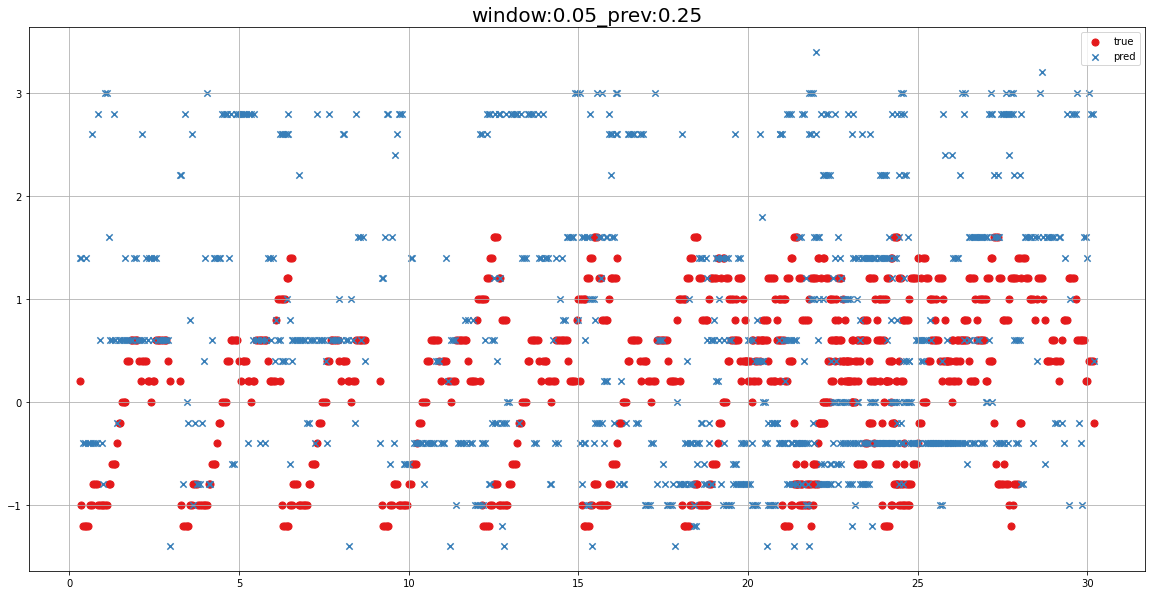

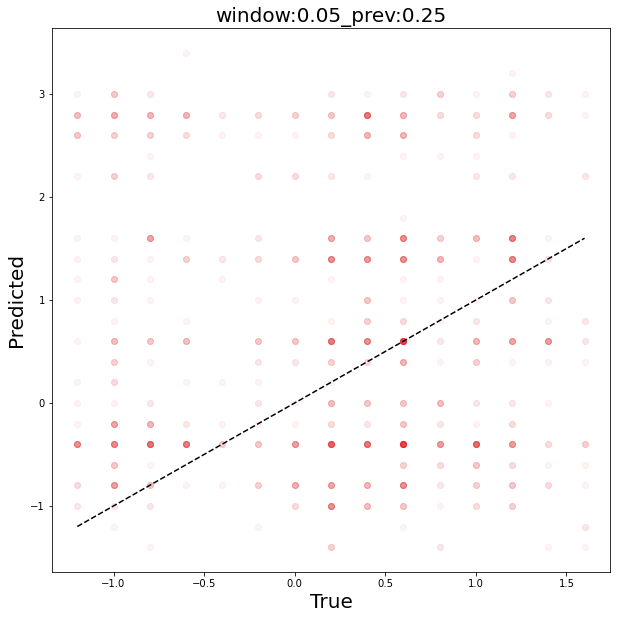

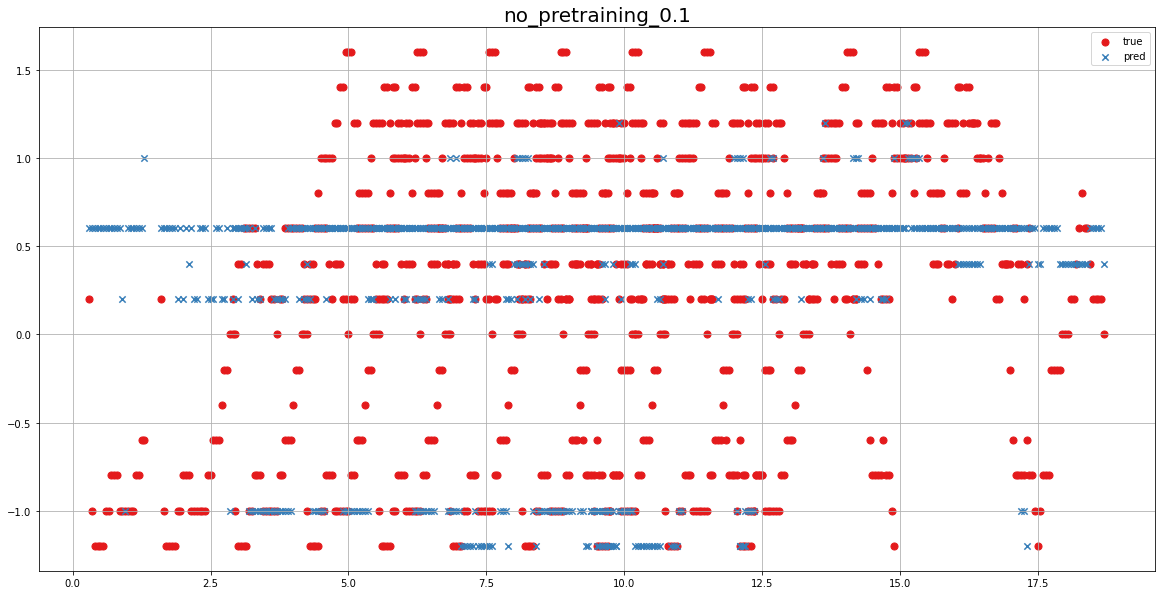

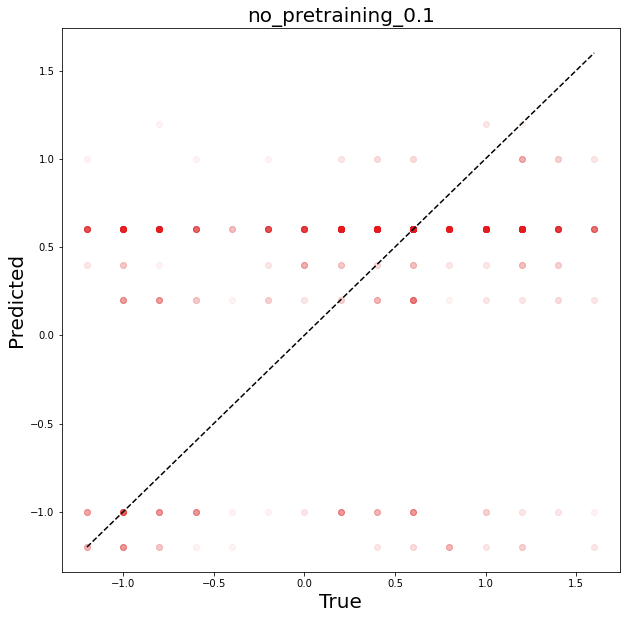

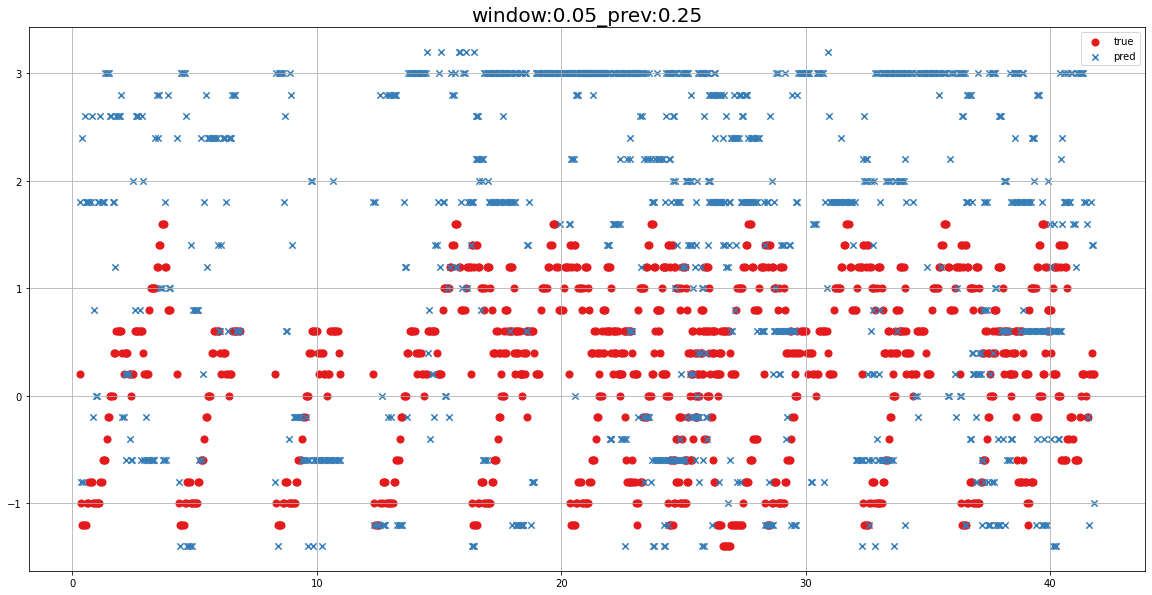

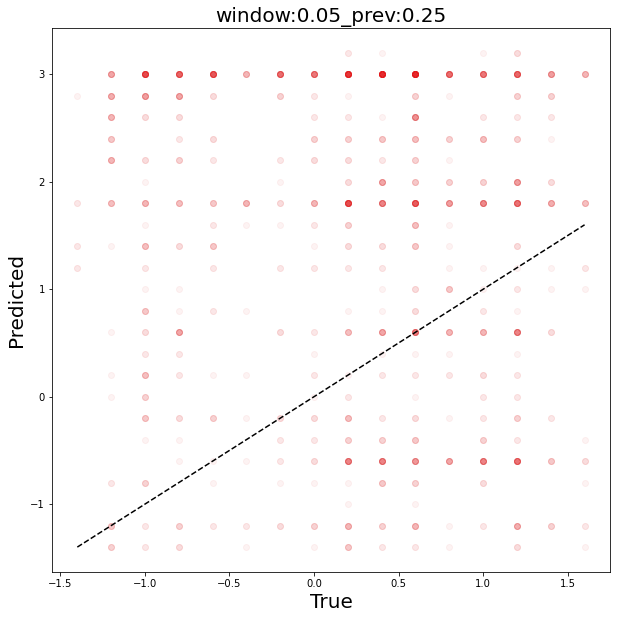

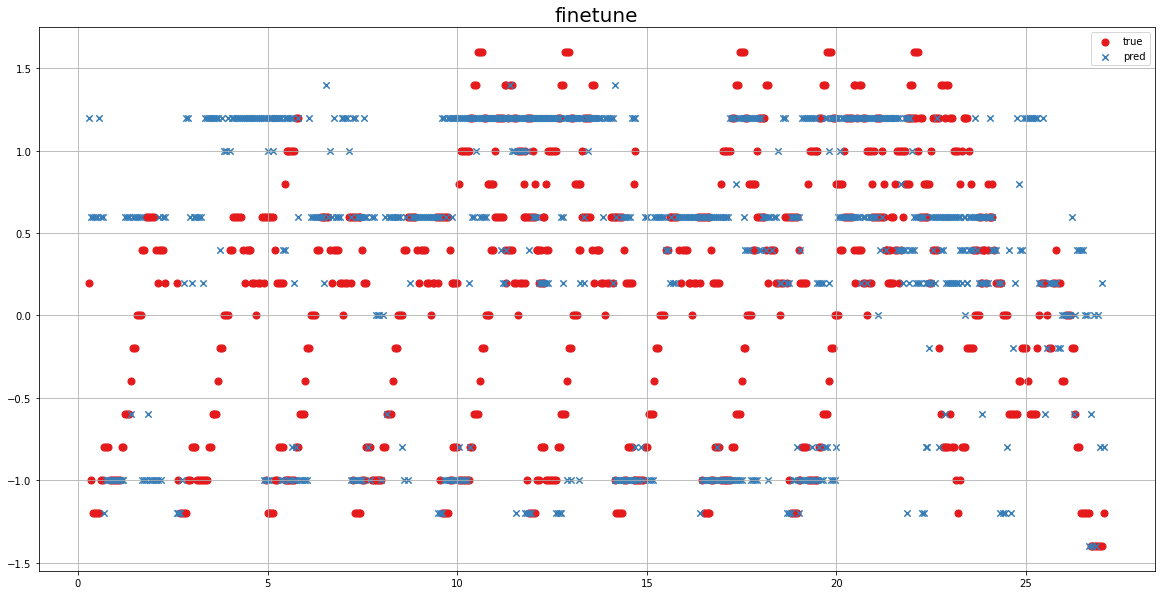

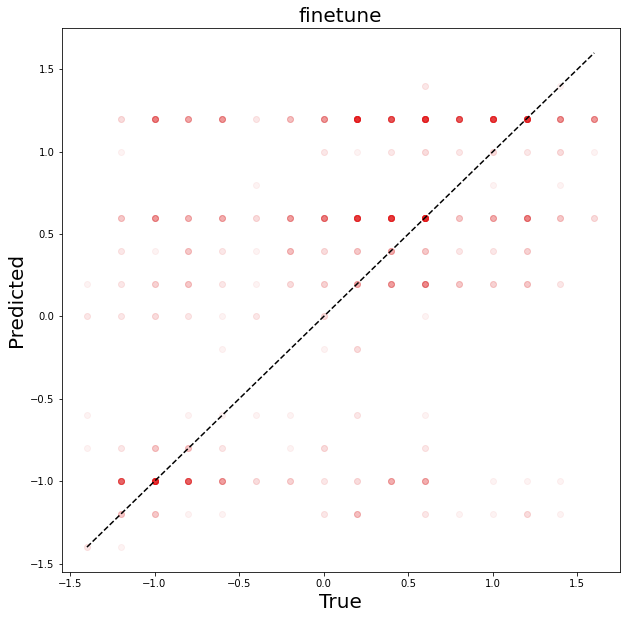

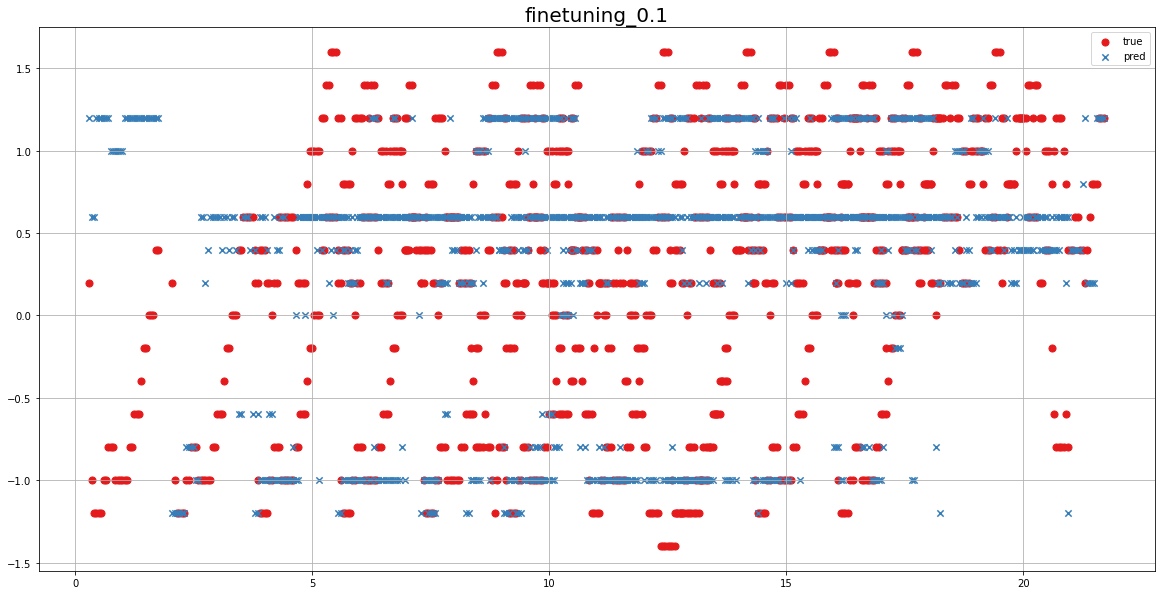

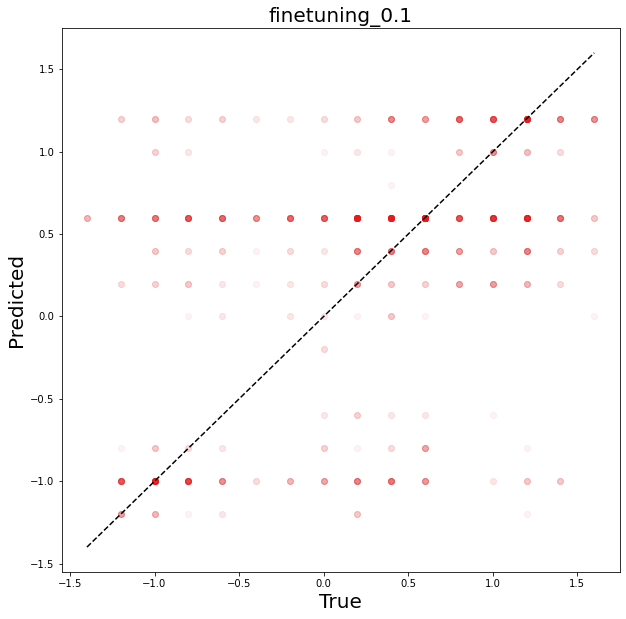

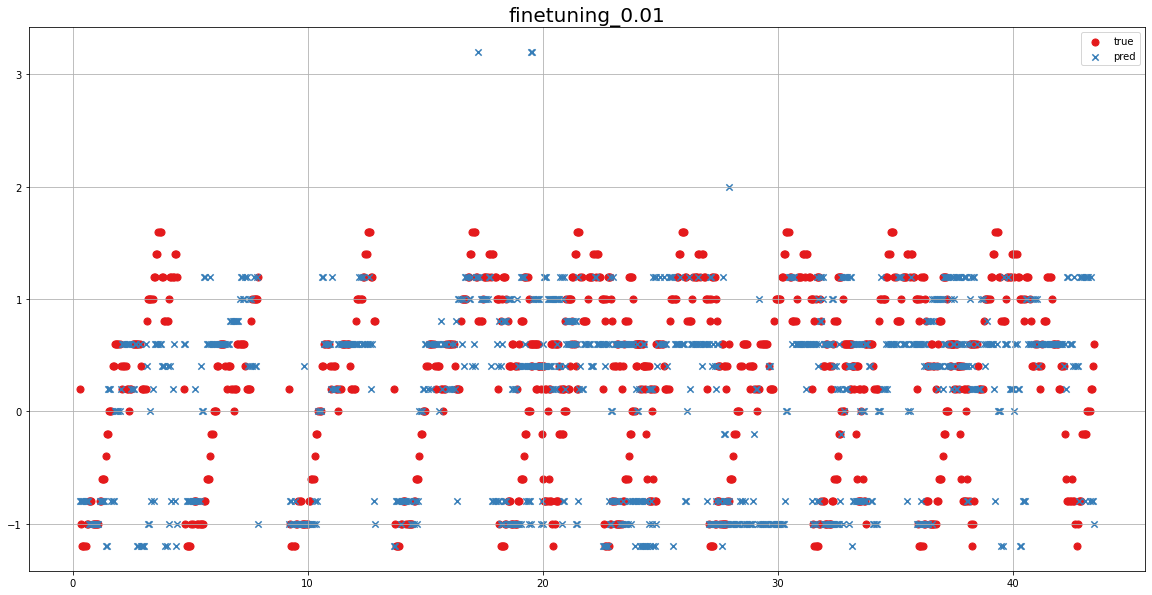

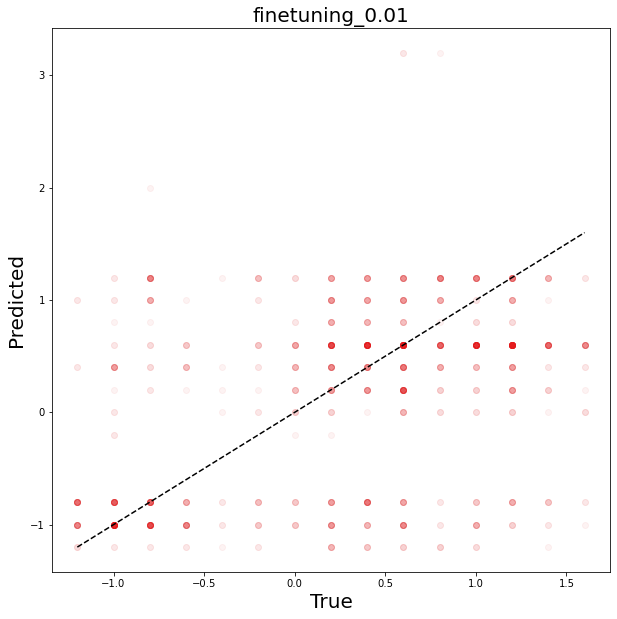

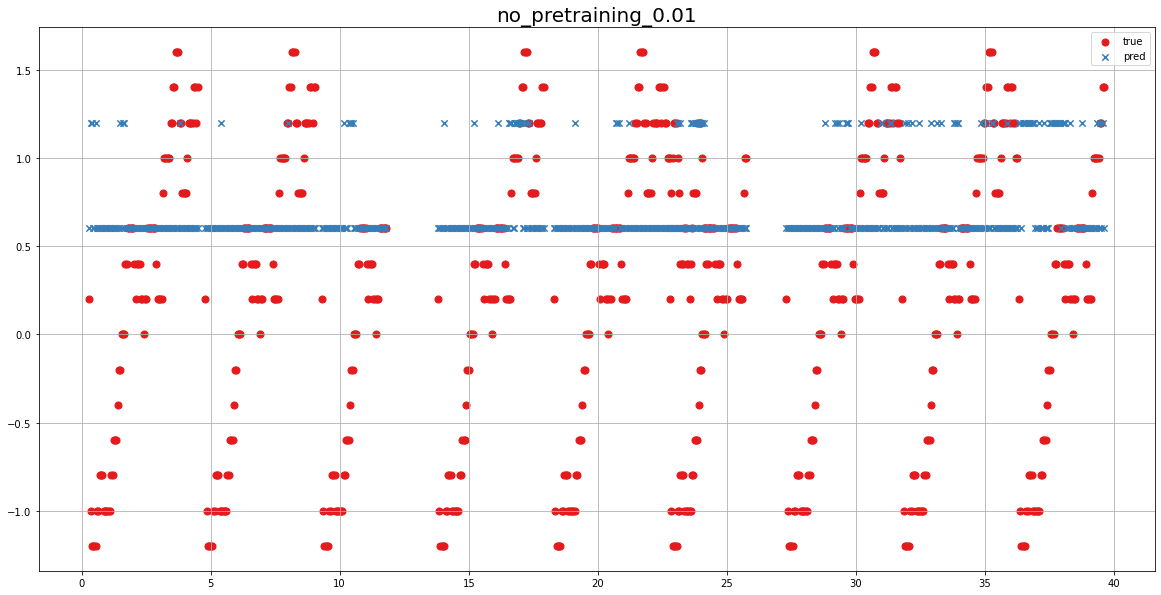

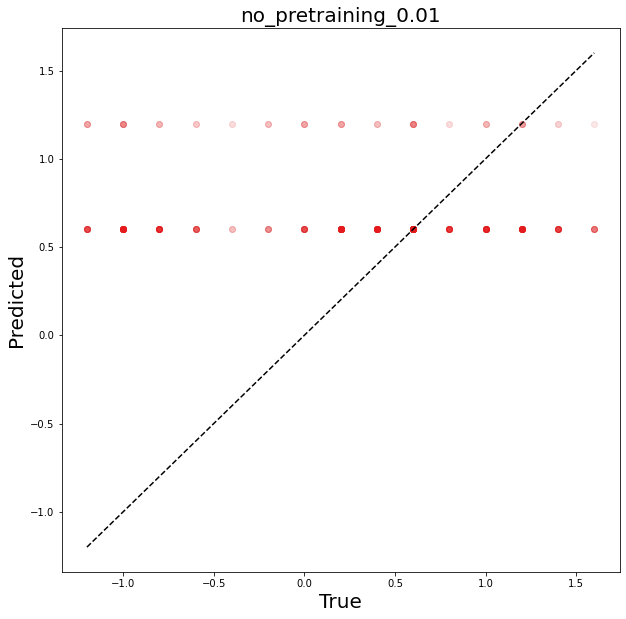

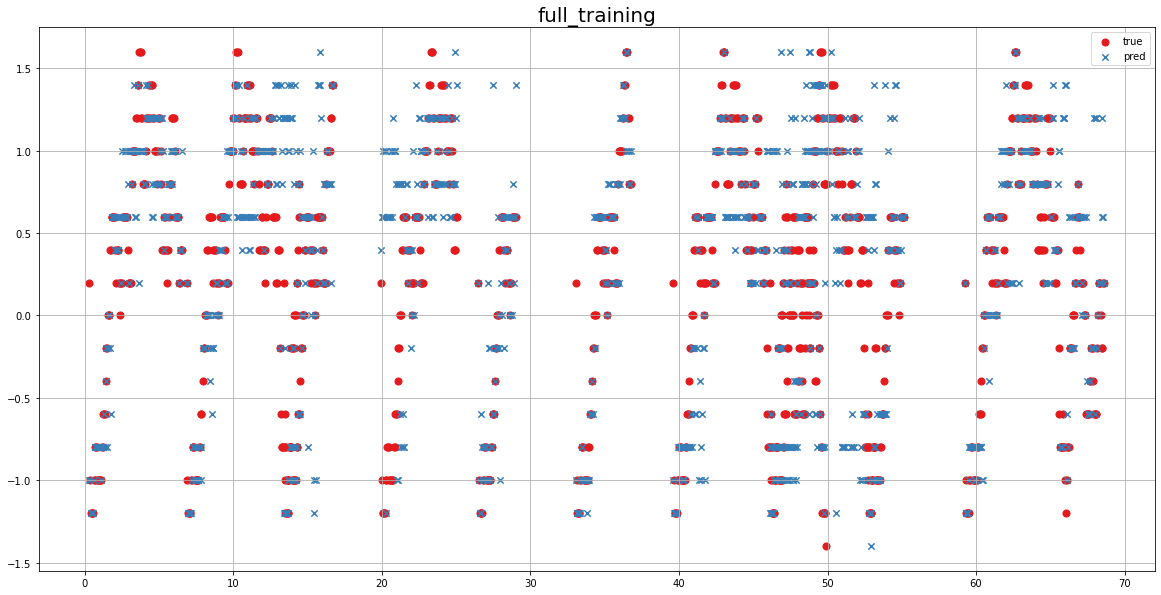

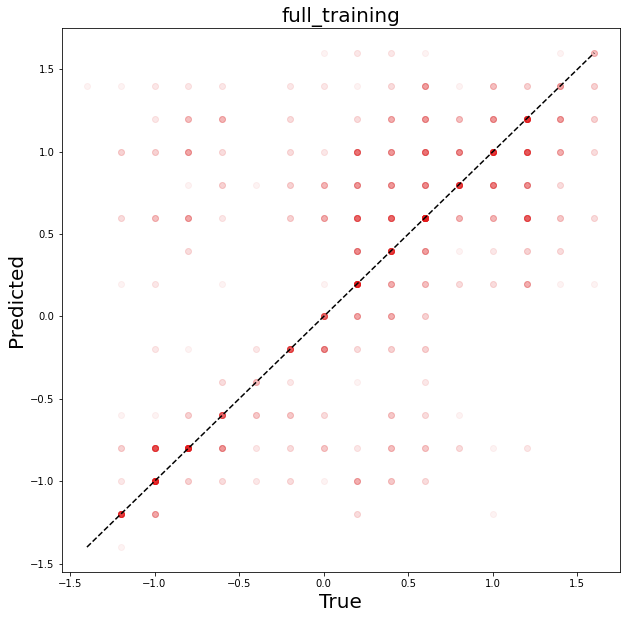

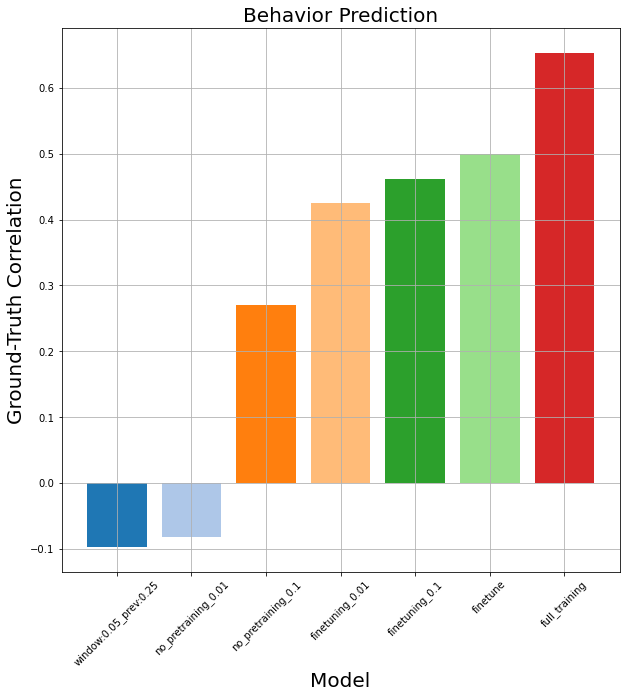

In [148]:

correlations = dict()
for model_dir in model_dirs:
    model_weights = model_dir.split("/")[6]
    # search in all subfolders to find the behavior_preds file
    behavior_pred_path = glob.glob(model_dir + "**/behavior_preds.csv", recursive=True)
    print(behavior_pred_path)
    if len(behavior_pred_path) > 0:
        behavior_pred_path = behavior_pred_path[0]
    else:
        continue
    behavior_preds = pd.read_csv(behavior_pred_path)

    from neuroformer.visualize import set_plot_white
    set_plot_white()

    plt.figure(figsize=(20, 10))
    plt.grid()
    ms = 10 * 4
    plt.scatter(behavior_preds['cum_interval'], behavior_preds['true'], s=ms + 10, label='true')
    plt.scatter(behavior_preds['cum_interval'], behavior_preds['behavior'], s=ms, label='pred', marker='x')
    plt.legend()

    plt.title(f"{model_weights}", fontsize=20)
    save_path = model_dir
    plt.savefig(os.path.join(save_path, f"preds_{model_weights.split('/')[-1].split('.')[0]}.png"))
    plt.savefig(os.path.join(save_path, f"preds_{model_weights.split('/')[-1].split('.')[0]}.svg"))

    # correlation plot
    plt.figure(figsize=(10, 10))
    fs = 20
    plt.scatter(behavior_preds['true'], behavior_preds['behavior'], alpha=0.05)
    plt.xlabel('True', fontsize=fs)
    plt.ylabel('Predicted', fontsize=fs)
    xy_axis = np.linspace(behavior_preds['true'].min(), behavior_preds['true'].max(), 1000)
    plt.plot(xy_axis, xy_axis, color='black', linestyle='--')
    plt.title(f"{model_weights}", fontsize=20)
    plt.savefig(os.path.join(save_path, f"corr_{model_weights.split('/')[-1].split('.')[0]}.png"))
    plt.savefig(os.path.join(save_path, f"corr_{model_weights.split('/')[-1].split('.')[0]}.svg"))

    correlaiton = np.corrcoef(behavior_preds['true'], behavior_preds['behavior'])[0, 1]
    correlations[model_weights] = correlaiton

# bar chart of correlations, different color for different model
# sort x values by correlation
correlations = collections.OrderedDict(sorted(correlations.items(), key=lambda x: x[1]))
cmap = plt.get_cmap('tab20')
plt.figure(figsize=(10, 10))
plt.grid()
plt.title("Behavior Prediction", fontsize=20)
plt.xlabel("Model", fontsize=20)
plt.ylabel("Ground-Truth Correlation", fontsize=20)
plt.bar(correlations.keys(), correlations.values(),
        color=[cmap(i) for i in range(len(correlations))])
# make tick labels at angle
plt.xticks(rotation=45)
plt.savefig(os.path.join("../models/tensorboard/visnav/behavior_predict/plots", f"corr_bar.png"))
plt.savefig(os.path.join("../models/tensorboard/visnav/behavior_predict/plots", f"corr_bar.svg"))

In [ ]:
model_dirs

['../models/tensorboard/visnav/behavior_predict/no_classification',
 '../models/tensorboard/visnav/behavior_predict/window:0.05_prev:0.25',
 '../models/tensorboard/visnav/behavior_predict/long_no_classification',
 '../models/tensorboard/visnav/behavior_predict/plots',
 '../models/tensorboard/visnav/behavior_predict/classification']